# Week 2 Project: Refining the Art of Sentiment Analysis at ModaMetric

Welcome to Week 2! The ModaMetric team is still buzzing from the achievements of last week. You've shown them the power of Metaflow and the potential of machine learning. However, there's more to explore, more to refine.

Once again, we’ll delve into the [Women's Ecommerce Clothing Reviews Dataset from Kaggle](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews), the dataset that helped us unlock valuable insights for ModaMetric. Your mission is to further refine the sentiment analysis process, enabling ModaMetric to better understand the sentiments embedded in the customer reviews.

## Task 1: Orchestrating the Dance of Sentiment Analysis Models with Metaflow

In this task, you'll utilize Metaflow to train two sentiment analysis models: the baseline "majority class" classifier and your own custom model. The models will be trained simultaneously, flexing the power of Metaflow. Your task also involves tweaking the models' hyperparameters for optimal performance. Finally, you'll analyze the performance of these models using Metaflow's Client API. Here's how you'll proceed:

### Step 1: Constructing the Sentiment Analysis Workflows
Your first task is to construct the Metaflow workflows. Begin with the baseline "majority class" classifier and then move on to your custom model. Make sure your custom model includes steps for data preprocessing, model training, and evaluation. Feel free to use techniques from Week 1 and any other [resources](https://outerbounds.com/docs/nlp-tutorial-L2/) you find useful.

### Step 2: Parallel Training of Models
Having built the models, you'll use Metaflow to train them simultaneously. The race is on - can the custom model outshine the baseline? If you find yourself in a bind, you might find the [FlowSpec branching documentation](https://docs.metaflow.org/metaflow/basics#branch) useful.

### Step 3: The Hyperparameters Experiment
Once you've trained the models, it's time for some fine-tuning. Experiment with different hyperparameters such as learning rate, batch size, and number of epochs. Record the performance of each model under different hyperparameter combinations as Data Artifacts in Metaflow.

### Step 4: Results Analysis
With the experiments complete, it's time to analyze the results. Use Metaflow's Client API to fetch the data and create visualizations to compare the models' performances. The goal is to identify the best hyperparameters for each model.

By completing this task, you're not only refining the sentiment analysis process at ModaMetric but also honing your own skills in orchestrating complex machine learning workflows using Metaflow.


In [1]:
from collections import Counter
import pandas as pd
import numpy as np
from termcolor import colored
import matplotlib.pyplot as plt
import seaborn as sns
import string

# You can style your plots here, but it is not part of the project.
YELLOW = "#FFBC00"
GREEN = "#37795D"
PURPLE = "#5460C0"
BACKGROUND = "#F4EBE6"
colors = [GREEN, PURPLE]
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.facecolor": BACKGROUND,
    "figure.facecolor": BACKGROUND,
    "figure.figsize": (8, 8),
}
sns_palette = sns.color_palette(colors, len(colors))
sns.set_theme(style="ticks", rc=custom_params)

In [2]:
def labeling_function(row):
    """
    A function to derive labels from the user's review data.
    This could use many variables, or just one.
    In supervised learning scenarios, this is a very important part of determining what the machine learns!

    A subset of variables in the e-commerce fashion review dataset to consider for labels you could use in ML tasks include:
        # rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
        # recommended_ind: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
        # positive_feedback_count: Positive Integer documenting the number of other customers who found this review positive.

    In this case, we are doing sentiment analysis.
    To keep things simple, we use the rating only, and return a binary positive or negative sentiment score based on an arbitrarty cutoff.
    """
    # TODO: Add your logic for the labelling function here
    # It is up to you on what value to choose as the cut off point for the postive class
    # A good value to start would be 4
    # This function should return either a 0 or 1 depending on the rating of a particular row
    return 1 if row["rating"] > 4 else 0

In [3]:
from sklearn.model_selection import train_test_split

# TODO: load the data.
df = pd.read_csv("../../full-stack-ml-metaflow-corise-week-1/data/Womens Clothing E-Commerce Reviews.csv")

# transformations
df.columns = ["_".join(name.lower().strip().split()) for name in df.columns]
df = df[~df.review_text.isna()]
df["review"] = df["review_text"].astype("str")
_has_review_df = df[df["review_text"] != "nan"]
reviews = _has_review_df["review_text"]
labels = _has_review_df.apply(labeling_function, axis=1)
df = pd.DataFrame({"label": labels, **_has_review_df})

# split into training and validation.
_df = pd.DataFrame({"review": reviews, "label": labels})
traindf, valdf = train_test_split(_df, test_size=0.2)

<AxesSubplot:xlabel='label', ylabel='Probability'>

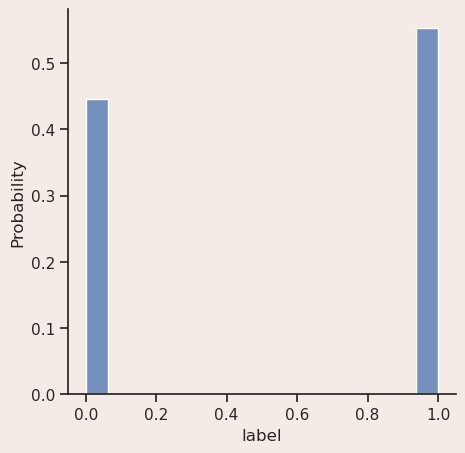

In [4]:
# TODO: build the majority class baseline model.
# TODO: find the majority class in the labels. 🤔
# TODO: score the model on valdf with a 2D metric space: sklearn.metrics.accuracy_score, sklearn.metrics.roc_auc_score
# Documentation on suggested model-scoring approach: https://scikit-learn.org/stable/modules/model_evaluation.html



fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# You can swap the color used with the defined constants at the top of the notebook
sns.histplot(traindf, x='label', stat='probability', ax=ax)

In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score
baseline_pred = np.full_like(valdf.label, 1)

base_acc = accuracy_score(valdf["label"], baseline_pred)
base_rocauc = roc_auc_score(valdf["label"], baseline_pred)
print(f"Baseline accuracy: {base_acc} \nBaseline ROC AUC: {base_rocauc}")

Baseline accuracy: 0.5535438286597483 
Baseline ROC AUC: 0.5


In [6]:
%%writefile model.py
# TODO: modify this custom model to your liking. Check out this tutorial for more on this class: https://outerbounds.com/docs/nlp-tutorial-L2/
# TODO: train the model on traindf.
# TODO: score the model on valdf with _the same_ 2D metric space you used in previous cell.
# TODO: test your model works by importing the model module in notebook cells, and trying to fit traindf and score predictions on the valdf data!

import tensorflow as tf
from tensorflow.keras import layers, optimizers, regularizers
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer


class NbowModel:
    def __init__(self, vocab_sz):
        self.vocab_sz = vocab_sz

        # Instantiate the CountVectorizer
        self.cv = CountVectorizer(
            min_df=0.005,
            max_df=0.75,
            stop_words="english",
            strip_accents="ascii",
            max_features=self.vocab_sz,
        )

        # Define the keras model
        inputs = tf.keras.Input(shape=(self.vocab_sz,), name="input")
        x = layers.Dropout(0.10)(inputs)
        x = layers.Dense(
            15,
            activation="relu",
            kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
        )(x)
        predictions = layers.Dense(
            1,
            activation="sigmoid",
        )(x)
        self.model = tf.keras.Model(inputs, predictions)
        opt = optimizers.Adam(learning_rate=0.002)
        self.model.compile(
            loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"]
        )

    def fit(self, X, y):
        print(X.shape)
        res = self.cv.fit_transform(X).toarray()
        print(res.shape)
        self.model.fit(x=res, y=y, batch_size=32, epochs=10, validation_split=0.2)

    def predict(self, X):
        print(X.shape)
        res = self.cv.transform(X).toarray()
        return self.model.predict(res)

    def eval_acc(self, X, labels, threshold=0.5):
        return accuracy_score(labels, self.predict(X) > threshold)

    def eval_rocauc(self, X, labels):
        return roc_auc_score(labels, self.predict(X))

    @property
    def model_dict(self):
        return {"vectorizer": self.cv, "model": self.model}

    @classmethod
    def from_dict(cls, model_dict):
        "Get Model from dictionary"
        nbow_model = cls(len(model_dict["vectorizer"].vocabulary_))
        nbow_model.model = model_dict["model"]
        nbow_model.cv = model_dict["vectorizer"]
        return nbow_model

if __name__ == "__main__":
    model = NbowModel(vocab_sz=700)
    model.fit(traindf.review, traindf.label)
    print(f"Baseline accuracy: {model.eval_acc(valdf.review, valdf.label)} \nBaseline ROC AUC: {model.eval_rocauc(valdf.review, valdf.label)}")

Overwriting model.py


In [20]:
%%writefile baseline_challenge.py
# TODO: In this cell, write your BaselineChallenge flow in the baseline_challenge.py file.

from metaflow import (
    FlowSpec,
    step,
    Flow,
    current,
    Parameter,
    IncludeFile,
    card,
    current,
)
from metaflow.cards import Table, Markdown, Artifact, Image
import numpy as np
from dataclasses import dataclass

# TODO: Define your labeling function here.
labeling_function = lambda row: 1 if row["rating"] > 4 else 0


@dataclass
class ModelResult:
    "A custom struct for storing model evaluation results."
    name: None
    params: None
    pathspec: None
    acc: None
    rocauc: None


class BaselineChallenge(FlowSpec):
    split_size = Parameter("split-sz", default=0.2)
    data = IncludeFile("data", default="Womens Clothing E-Commerce Reviews.csv")
    kfold = Parameter("k", default=5)
    scoring = Parameter("scoring", default="accuracy")

    @step
    def start(self):
        import pandas as pd
        import io
        from sklearn.model_selection import train_test_split

        # load dataset packaged with the flow.
        # this technique is convenient when working with small datasets that need to move to remove tasks.
        # TODO: load the data.
        df = pd.read_csv(io.StringIO(self.data))
        # Look up a few lines to the IncludeFile('data', default='Womens Clothing E-Commerce Reviews.csv').
        # You can find documentation on IncludeFile here: https://docs.metaflow.org/scaling/data#data-in-local-files

        # filter down to reviews and labels
        df.columns = ["_".join(name.lower().strip().split()) for name in df.columns]
        df = df[~df.review_text.isna()]
        df["review"] = df["review_text"].astype("str")
        _has_review_df = df[df["review_text"] != "nan"]
        reviews = _has_review_df["review_text"]
        labels = _has_review_df.apply(labeling_function, axis=1)
        self.df = pd.DataFrame({"label": labels, **_has_review_df})

        # split the data 80/20, or by using the flow's split-sz CLI argument
        _df = pd.DataFrame({"review": reviews, "label": labels})
        self.traindf, self.valdf = train_test_split(_df, test_size=self.split_size)
        print(f"num of rows in train set: {self.traindf.shape[0]}")
        print(f"num of rows in validation set: {self.valdf.shape[0]}")

        self.next(self.baseline, self.model)

    @step
    def baseline(self):
        "Compute the baseline"

        from sklearn.metrics import accuracy_score, roc_auc_score

        self._name = "baseline"
        params = "Always predict 1"
        pathspec = f"{current.flow_name}/{current.run_id}/{current.step_name}/{current.task_id}"

        # TODO: predict the majority class
        predictions = np.full_like(self.valdf.label, 1)
        # TODO: return the accuracy_score of these predictions
        acc = accuracy_score(self.valdf["label"], predictions)

        # TODO: return the roc_auc_score of these predictions
        rocauc = roc_auc_score(self.valdf["label"], predictions)
        self.result = ModelResult("Baseline", params, pathspec, acc, rocauc)
        self.next(self.aggregate)

    @step
    def model(self):
        # TODO: import your model if it is defined in another file.
        from model import NbowModel
        self._name = "model"
        # NOTE: If you followed the link above to find a custom model implementation,
        # you will have noticed your model's vocab_sz hyperparameter.
        # Too big of vocab_sz causes an error. Can you explain why?
        self.hyperparam_set = [{"vocab_sz": 100}, {"vocab_sz": 300}, {"vocab_sz": 500}]
        pathspec = f"{current.flow_name}/{current.run_id}/{current.step_name}/{current.task_id}"

        self.results = []
        for params in self.hyperparam_set:
            model = NbowModel(params["vocab_sz"])  # TODO: instantiate your custom model here!
            model.fit(X=self.traindf["review"], y=self.traindf["label"])
            predictions = model.predict(self.valdf)
            # TODO: evaluate your custom model in an equivalent way to accuracy_score.
            acc = accuracy_score(self.valdf["label"], predictions)
            # TODO: evaluate your custom model in an equivalent way to roc_auc_score.
            rocauc = roc_auc_score(self.valdf["label"], predictions)
            self.results.append(
                ModelResult(
                    f"NbowModel - vocab_sz: {params['vocab_sz']}",
                    params,
                    pathspec,
                    acc,
                    rocauc,
                )
            )

        self.next(self.aggregate)

    @step
    def aggregate(self):
        self.next(self.end)

    @step
    def end(self):
        pass


if __name__ == "__main__":
    BaselineChallenge()

Overwriting baseline_challenge.py


In [10]:
! python baseline_challenge.py

Metaflow 2.9.7.2+ob(v1) executing BaselineChallenge for user:sandbox
Validating your flow...
    Validity checker found an issue:
    Step end reached before a split started at step(s) baseline, model were joined. Add a join step before end.



## Task 2: Mastering the Art of Anticipation: Failures and Remedies in ModaMetric's Machine Learning Journey

In this task, your challenge is to step into the role of a foresightful data scientist at ModaMetric, where you'll be anticipating potential pitfalls in the sentiment analysis classifier project. Not just that, but you'll also be charting out strategies to steer clear of these hitches. Here's how you'll navigate through:

### Step 1: Forecasting Potential Failure Modes

The key to overcoming challenges is to anticipate them. Start by picturing possible failure scenarios from an engineering perspective. For instance, you might think about problems like overfitting to the training data or biases in the data. Remember, the first step to finding a solution is acknowledging the problem.

### Step 2: Strategizing to Mitigate Failure Modes

Having identified the potential obstacles, your next task is to devise counter-strategies. Consider what steps you'd take to address the problem if it arises. For instance, to counter overfitting, you could employ regularization techniques such as L1 or L2 regularization. Think of this step as drawing up a contingency plan.

### Step 3: Planning Ahead to Dodge Failure Modes

Beyond reactive strategies, you also need a proactive plan. What could you have done at the outset to avoid these potential pitfalls? Could you have collected a more diverse dataset to reduce bias? Or experimented with different model architectures? The goal is to minimize reactive measures and maximize foresight.

This task emphasizes the importance of anticipation in machine learning projects. By identifying possible failure modes and crafting mitigation strategies, you'll be preparing yourself for a smooth-sailing machine learning journey at ModaMetric.


## Task 3: Bringing ML Results to Life: ModaMetric's Visualization Adventure with MF Cards

It's time for you to go beyond the code and transform data into a visual narrative. As a member of ModaMetric's data science team, your next mission is to enhance the existing flow in your `baseline_challenge.py` file. Add a new layer that gathers the results from all the hyperparameter tuning jobs. But that's not all - you're also going to breathe life into this aggregated data by creating a data visualization using Metaflow cards. Here's what you need to do:

### Step 1: Extend Your Flow

Your first challenge is to add another level to your existing `baseline_challenge.py` file. This new addition should be able to collate all the outcomes from your various hyperparameter tuning jobs. 

### Step 2: Log Results and Create Data Visualization

Once you've collected the outcomes, it's time to log the results in a structured way. Then, you're going to take this information and create a compelling data visualization using Metaflow cards. Remember, a picture is worth a thousand numbers. With these visual insights, you'll be enabling ModaMetric to understand the performance of your machine learning model in a glance.

This task is your opportunity to blend your technical skills with creative thinking. By visualizing your ML results, you're not only making the data more digestible but also contributing to ModaMetric's data-driven decision-making process.

In [24]:
%%writefile baseline_challenge.py
# TODO: In this cell, write your BaselineChallenge flow in the baseline_challenge.py file.

from metaflow import (
    FlowSpec,
    step,
    Flow,
    current,
    Parameter,
    IncludeFile,
    card,
    current,
)
from metaflow.cards import Table, Markdown, Artifact, Image
import numpy as np
from dataclasses import dataclass

# TODO: Define your labeling function here.
labeling_function = lambda row: 1 if row["rating"] > 4 else 0


@dataclass
class ModelResult:
    "A custom struct for storing model evaluation results."
    name: None
    params: None
    pathspec: None
    acc: None
    rocauc: None


class BaselineChallenge(FlowSpec):
    split_size = Parameter("split-sz", default=0.2)
    data = IncludeFile("data", default="Womens Clothing E-Commerce Reviews.csv")
    kfold = Parameter("k", default=5)
    scoring = Parameter("scoring", default="accuracy")

    @step
    def start(self):
        import pandas as pd
        import io
        from sklearn.model_selection import train_test_split

        # load dataset packaged with the flow.
        # this technique is convenient when working with small datasets that need to move to remove tasks.
        # TODO: load the data.
        df = pd.read_csv(io.StringIO(self.data))
        # Look up a few lines to the IncludeFile('data', default='Womens Clothing E-Commerce Reviews.csv').
        # You can find documentation on IncludeFile here: https://docs.metaflow.org/scaling/data#data-in-local-files

        # filter down to reviews and labels
        df.columns = ["_".join(name.lower().strip().split()) for name in df.columns]
        df = df[~df.review_text.isna()]
        df["review"] = df["review_text"].astype("str")
        _has_review_df = df[df["review_text"] != "nan"]
        reviews = _has_review_df["review_text"]
        labels = _has_review_df.apply(labeling_function, axis=1)
        self.df = pd.DataFrame({"label": labels, **_has_review_df})

        # split the data 80/20, or by using the flow's split-sz CLI argument
        _df = pd.DataFrame({"review": reviews, "label": labels})
        self.traindf, self.valdf = train_test_split(_df, test_size=self.split_size)
        print(f"num of rows in train set: {self.traindf.shape[0]}")
        print(f"num of rows in validation set: {self.valdf.shape[0]}")

        self.next(self.baseline, self.model)

    @step
    def baseline(self):
        "Compute the baseline"

        from sklearn.metrics import accuracy_score, roc_auc_score

        self._name = "baseline"
        params = "Always predict 1"
        pathspec = f"{current.flow_name}/{current.run_id}/{current.step_name}/{current.task_id}"

        # TODO: predict the majority class
        predictions = np.full_like(self.valdf.label, 1)
        # TODO: predict the majority class
        predictions = np.full_like(self.valdf.label, 1)
        # TODO: return the accuracy_score of these predictions
        acc = accuracy_score(self.valdf["label"], predictions)
        rocauc = roc_auc_score(self.valdf["label"], predictions)
        self.result = ModelResult("Baseline", params, pathspec, acc, rocauc)
        self.next(self.aggregate)

    @step
    def model(self):
        # TODO: import your model if it is defined in another file.
        from model import NbowModel
        self._name = "model"
        # NOTE: If you followed the link above to find a custom model implementation,
        # you will have noticed your model's vocab_sz hyperparameter.
        # Too big of vocab_sz causes an error. Can you explain why?
        self.hyperparam_set = [{"vocab_sz": 100}, {"vocab_sz": 300}, {"vocab_sz": 500}]
        pathspec = f"{current.flow_name}/{current.run_id}/{current.step_name}/{current.task_id}"

        self.results = []
        for params in self.hyperparam_set:
            # TODO: instantiate your custom model here!
            model = NbowModel(params["vocab_sz"])
            model.fit(X=self.traindf["review"], y=self.traindf["label"])
            # TODO: evaluate your custom model in an equivalent way to accuracy_score.
            acc = model.eval_acc(self.valdf.review, self.valdf.label)
            # TODO: evaluate your custom model in an equivalent way to roc_auc_score.
            rocauc = model.eval_rocauc(self.valdf.review, self.valdf.label)
            self.results.append(
                ModelResult(
                    f"NbowModel - vocab_sz: {params['vocab_sz']}",
                    params,
                    pathspec,
                    acc,
                    rocauc,
                )
            )

        self.next(self.aggregate)

    def add_one(self, rows, result, df):
        "A helper function to load results."
        rows.append(
            [
                Markdown(result.name),
                Artifact(result.params),
                Artifact(result.pathspec),
                Artifact(result.acc),
                Artifact(result.rocauc),
            ]
        )
        df["name"].append(result.name)
        df["accuracy"].append(result.acc)
        return rows, df

    @card(type='corise')  # TODO: Set your card type to "corise".
    # I wonder what other card types there are?
    # https://docs.metaflow.org/metaflow/visualizing-results
    # https://github.com/outerbounds/metaflow-card-altair/blob/main/altairflow.py
    @step
    def aggregate(self, inputs):
        import seaborn as sns
        import matplotlib.pyplot as plt
        from matplotlib import rcParams

        rcParams.update({"figure.autolayout": True})

        rows = []
        violin_plot_df = {"name": [], "accuracy": []}
        for task in inputs:
            if task._name == "model":
                for result in task.results:
                    print(result)
                    rows, violin_plot_df = self.add_one(rows, result, violin_plot_df)
            elif task._name == "baseline":
                print(task.result)
                rows, violin_plot_df = self.add_one(rows, task.result, violin_plot_df)
            else:
                raise ValueError("Unknown task._name type. Cannot parse results.")

        current.card.append(Markdown("# All models from this flow run"))

        # TODO: Add a Table of the results to your card!
        current.card.append(
            Table(
                rows,  # TODO: What goes here to populate the Table in the card?
                headers=["Model name", "Params", "Task pathspec", "Accuracy", "ROCAUC"],
            )
        )

        fig, ax = plt.subplots(1, 1)
        plt.xticks(rotation=40)
        sns.violinplot(data=violin_plot_df, x="name", y="accuracy", ax=ax)

        # TODO: Append the matplotlib fig to the card
        # Docs: https://docs.metaflow.org/metaflow/visualizing-results/easy-custom-reports-with-card-components#showing-plots

        self.next(self.end)

    @step
    def end(self):
        pass


if __name__ == "__main__":
    BaselineChallenge()

Overwriting baseline_challenge.py


In [25]:
! python baseline_challenge.py run --data "../../full-stack-ml-metaflow-corise-week-1/data/Womens Clothing E-Commerce Reviews.csv"

Metaflow 2.9.7.2+ob(v1) executing BaselineChallenge for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Including file ../../full-stack-ml-metaflow-corise-week-1/data/Womens Clothing E-Commerce Reviews.csv of size 8MB 
2023-10-29 06:24:08.399 Workflow starting (run-id 8), see it in the UI at https://ui-pw-1448258003.outerbounds.dev/BaselineChallenge/8
2023-10-29 06:24:08.645 [8/start/29 (pid 6881)] Task is starting.
2023-10-29 06:24:12.442 [8/start/29 (pid 6881)] num of rows in train set: 18112
2023-10-29 06:24:16.388 [8/start/29 (pid 6881)] num of rows in validation set: 4529
2023-10-29 06:24:16.728 [8/start/29 (pid 6881)] Task finished successfully.
2023-10-29 06:24:17.078 [8/baseline/30 (pid 6989)] Task is starting.
2023-10-29 06:24:17.274 [8/model/31 (pid 6992)] Task is starting.
2023-10-29 06:24:19.449 [8/model/31 (pid 6992)] 2023-10-29 06:24:19.449798: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary

## Task 4: Exploring Advanced Visualization Opportunities with MF Cards (Optional)

As ModaMetric continues to thrive and grow, it's clear that basic visualizations won't be enough to understand the intricate dynamics of our e-commerce customer sentiment. We want to take our data storytelling to the next level. And you, as a valued member of our data science team, are the perfect person to lead this initiative.

This optional task is an open invitation for you to really explore how you can leverage Metaflow's features to deliver a compelling, multidimensional story.

### Step 1: Dive Deeper into Hyperparameter Tuning Insights

While we have already visualized the results of the hyperparameter tuning, we believe there's more to unearth. Consider how you might visualize the correlation between specific hyperparameters and model performance, or how different hyperparameter combinations affect the training time.

### Step 2: Unearth Hidden Trends in Customer Sentiment

ModaMetric prides itself on delivering the best for our customers. Can we use our sentiment analysis data to learn more about our customer preferences? Try to create visualizations that show trends in sentiment across different clothing categories, times of year, or any other dimension you find interesting.

### Step 3: Explore Advanced Visualization Techniques

Metaflow can accommodate a wide range of data visualization techniques. This is your chance to showcase those advanced skills. Perhaps you could experiment with multi-panel plots, 3D visualizations, or interactive plots that let viewers explore the data for themselves. You can refer to this [blog post](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwjJwOe55pqAAxXA6KACHTZzAsoQFnoECCAQAQ&url=https%3A%2F%2Fouterbounds.com%2Fblog%2Fintegrating-pythonic-visual-reports-into-ml-pipelines%2F&usg=AOvVaw2PY3huULq5xR3yZEQ1s-OL&opi=89978449) for more information about how you may do this. 

We're looking forward to seeing where your creativity and technical expertise can lead ModaMetric. Remember, there are no boundaries - the sky's the limit!